In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Change the path to point to your actual data file
recommendation_data = pd.read_excel('/content/drive/My Drive/Recommendation_data.xlsx')

print(recommendation_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   customer_id    Recommendation_name Recommendation_date suggestion_type  \
0          1.0  Recommend_screenguard          2021-07-02      With phone   
1          2.0  Recommend_screenguard          2021-07-03      With phone   
2          3.0  Recommend_screenguard          2021-07-04      With cover   
3          4.0  Recommend_screenguard          2021-07-05      With phone   
4          5.0  Recommend_screenguard          2021-07-06      With cover   

   purchase_flag  
0            0.0  
1            0.0  
2            1.0  
3            0.0  
4            1.0  


In [5]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from math import sqrt
import numpy as np


# Group the data for A/B testing
grouped_data = recommendation_data.groupby('suggestion_type')['purchase_flag'].value_counts().unstack().fillna(0)

# Calculate purchase rates
purchase_rates = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(grouped_data)

# Display grouped data and purchase rates
print("Grouped Data:\n", grouped_data)
print("\nPurchase Rates:\n", purchase_rates)
print("\nChi-Square Test Results:\nChi2 =", chi2, "\np-value =", p, "\nDegrees of Freedom =", dof)


Grouped Data:
 purchase_flag    0.0  1.0
suggestion_type          
With cover       206  130
With phone       258  117

Purchase Rates:
 purchase_flag         0.0       1.0
suggestion_type                    
With cover       0.613095  0.386905
With phone       0.688000  0.312000

Chi-Square Test Results:
Chi2 = 4.061579280024079 
p-value = 0.04386945305215398 
Degrees of Freedom = 1


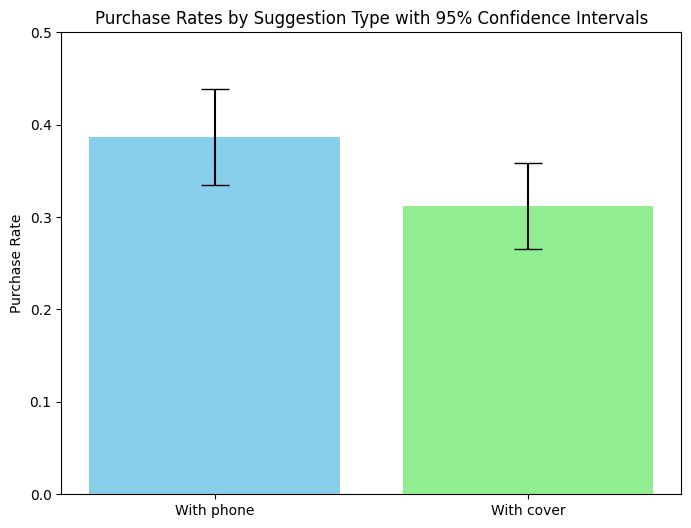


Confidence Intervals for Purchase Rates:
                 Suggestion Type  Purchase Rate  Lower Bound  Upper Bound
suggestion_type                                                         
With cover           With phone       0.386905     0.334828     0.438982
With phone           With cover       0.312000     0.265107     0.358893

Effect Size (Cohen's h): -0.15731071627744453


In [6]:
# Calculate confidence intervals for purchase rates
confidence_intervals = proportion_confint(count=grouped_data[1], nobs=grouped_data.sum(axis=1), alpha=0.05, method='normal')

# Calculate effect size (Cohen's h)
def cohen_h(p1, p2):
    return 2 * (np.arcsin(sqrt(p1)) - np.arcsin(sqrt(p2)))

effect_size = cohen_h(purchase_rates.loc['With phone', 1], purchase_rates.loc['With cover', 1])

# Prepare data for visualization
suggestion_types = ['With phone', 'With cover']
purchase_rates_values = purchase_rates[1].values
lower_bounds = confidence_intervals[0]
upper_bounds = confidence_intervals[1]

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(suggestion_types, purchase_rates_values, yerr=[purchase_rates_values - lower_bounds, upper_bounds - purchase_rates_values], capsize=10, color=['skyblue', 'lightgreen'])
ax.set_ylabel('Purchase Rate')
ax.set_title('Purchase Rates by Suggestion Type with 95% Confidence Intervals')
plt.ylim(0, 0.5)
plt.show()

# Display confidence intervals
confidence_intervals_df = pd.DataFrame({
    'Suggestion Type': suggestion_types,
    'Purchase Rate': purchase_rates_values,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})
print("\nConfidence Intervals for Purchase Rates:\n", confidence_intervals_df)
print("\nEffect Size (Cohen's h):", effect_size)


In [7]:
from scipy.stats import ttest_ind

# Extract purchase flags for each suggestion type
purchase_with_phone = recommendation_data[recommendation_data['suggestion_type'] == 'With phone']['purchase_flag'].dropna()
purchase_with_cover = recommendation_data[recommendation_data['suggestion_type'] == 'With cover']['purchase_flag'].dropna()

# Perform the T-test
t_stat, p_value = ttest_ind(purchase_with_phone, purchase_with_cover)

# Display the results
t_test_results = pd.DataFrame({
    'Metric': ['T-statistic', 'p-value'],
    'Value': [t_stat, p_value]
})

t_test_results


,Metric,Value
0,T-statistic,-2.097751
1,p-value,0.036281


In [8]:
#effect size calcualtion
def cohen_d(x, y):
    # Calculate the size of samples
    n_x = len(x)
    n_y = len(y)

    # Calculate the variance of the samples
    var_x = x.var(ddof=1)
    var_y = y.var(ddof=1)

    # Calculate the pooled standard deviation
    pooled_std = sqrt(((n_x - 1) * var_x + (n_y - 1) * var_y) / (n_x + n_y - 2))

    # Calculate Cohen's d
    d = (x.mean() - y.mean()) / pooled_std
    return d

# Calculate Cohen's d
effect_size_d = cohen_d(purchase_with_phone, purchase_with_cover)

# Display the effect size
effect_size_d


-0.15758086648738373

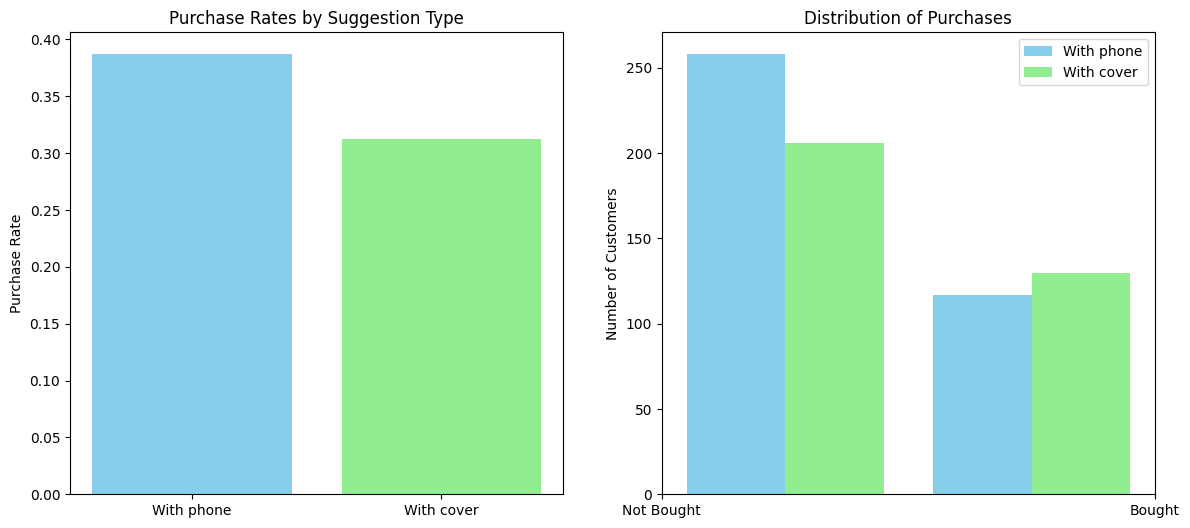

purchase_flag               0.0       1.0
Month suggestion_type                    
1.0   With cover       0.600000  0.400000
      With phone       0.608696  0.391304
2.0   With cover       0.666667  0.333333
      With phone       0.750000  0.250000
3.0   With cover       0.565217  0.434783
      With phone       0.840000  0.160000
4.0   With cover       0.615385  0.384615
      With phone       0.653846  0.346154
5.0   With cover       0.750000  0.250000
      With phone       0.727273  0.272727
6.0   With cover       0.826087  0.173913
      With phone       0.880000  0.120000
7.0   With cover       0.578947  0.421053
      With phone       0.756098  0.243902
8.0   With cover       0.424242  0.575758
      With phone       0.558140  0.441860
9.0   With cover       0.464286  0.535714
      With phone       0.439024  0.560976
10.0  With cover       0.575000  0.425000
      With phone       0.666667  0.333333
11.0  With cover       0.566667  0.433333
      With phone       0.815789  0.184211
12.0  With cover       0.909091  0.090909
      With phone       0.703704  0.296296

In [11]:
# Step 1: Effect Size Calculation (Cohen's d)
def cohen_d(x, y):
    n_x = len(x)
    n_y = len(y)
    var_x = x.var(ddof=1)
    var_y = y.var(ddof=1)
    pooled_std = sqrt(((n_x - 1) * var_x + (n_y - 1) * var_y) / (n_x + n_y - 2))
    d = (x.mean() - y.mean()) / pooled_std
    return d

# Calculate Cohen's d
effect_size_d = cohen_d(purchase_with_phone, purchase_with_cover)

# Step 2: Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot purchase rates
ax[0].bar(['With phone', 'With cover'], purchase_rates[1], color=['skyblue', 'lightgreen'])
ax[0].set_ylabel('Purchase Rate')
ax[0].set_title('Purchase Rates by Suggestion Type')

# Plot distribution of purchases
ax[1].hist([purchase_with_phone, purchase_with_cover], bins=2, color=['skyblue', 'lightgreen'], label=['With phone', 'With cover'])
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Not Bought', 'Bought'])
ax[1].set_ylabel('Number of Customers')
ax[1].set_title('Distribution of Purchases')
ax[1].legend()

plt.show()

# Step 3: Customer Segmentation Analysis
recommendation_data['Recommendation_date'] = pd.to_datetime(recommendation_data['Recommendation_date'])
recommendation_data['Month'] = recommendation_data['Recommendation_date'].dt.month

# Group by month and suggestion type
monthly_grouped_data = recommendation_data.groupby(['Month', 'suggestion_type'])['purchase_flag'].value_counts().unstack().fillna(0)

# Calculate purchase rates per month
monthly_purchase_rates = monthly_grouped_data.div(monthly_grouped_data.sum(axis=1), axis=0)

# Display monthly purchase rates
monthly_purchase_rates
